# Import needed modules and useful functions

In [7]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [8]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':100000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

# Prepare input files for plumed

In [9]:
folder = "test_tprime/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),"""PERIODIC=NO
ene: BIASVALUE ARG=potential

# definition of Deep-TICA cvs 
deep: PYTORCH_MODEL FILE=../unbias/deeptica/model.ptc ARG=p.x,p.y

# Bias 
opes: OPES_METAD ARG=deep.node-0,deep.node-1 TEMP=0.5 PACE=500 FILE=KERNELS BARRIER=7.5 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10

#print logweights
PRINT ARG=opes.bias FILE=Tprime STRIDE=1

# Print 
# STRIDE=200 so that the printed time is in 1 ps
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=deep.node-0,deep.node-1,p.x,p.y,ene.bias,opes.*

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data "+folder,folder=".")
#-- run plumed --#
#execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data test_tprime/
Completed: plumed ves_md_linearexpansion input


# Tprime Analysis 
```py
def tprime_evaluation(t=None,logweights=None):

    # rescale time with log-weights if given
    if logweights is not None:
        # compute time increment in simulation time t
        dt = np.round(t[1]-t[0],3)
        # sanitize logweights
        logweights = torch.Tensor(logweights)
        logweights -= torch.max(logweights)
        lognorm = torch.logsumexp(logweights,0)
        logweights /= lognorm
        # compute instantaneus time increment in rescaled time t'
        d_tprime = torch.exp(logweights)*dt
        # calculate cumulative time t'
        tprime = torch.cumsum(d_tprime,0)
    else:
        tprime = t

    return tprime
```

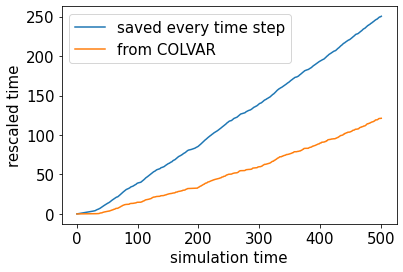

In [10]:
#-- Tprime file rimosso.. per questa run 286 MB --#
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p.').columns.values
time_data = load_dataframe(folder+"Tprime")
X = data[descriptors_names].to_numpy()

tprime = (tprime_evaluation(t=time_data["time"],logweights = 2*time_data["opes.bias"])).numpy()
# stride di 200 
size = int(len(tprime)/200)
tprime = tprime[::200]
t = np.linspace(0,len(tprime),len(tprime))
plt.plot(t,tprime,label="saved every time step")
tprime = tprime_evaluation(t=data["time"], logweights = 2*data["opes.bias"]).numpy()
t = np.linspace(0,len(tprime),len(tprime))
plt.plot(t,tprime,label="from COLVAR")
plt.xlabel("simulation time")
plt.ylabel("rescaled time")
plt.legend()

In [ ]:
#-- estimation of Free Energy Surface 1D --#
s = load_dataframe(folder+"COLVAR").filter(regex="^p").to_numpy()
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0]/sim_parameters["temp"]

fig, ax = plt.subplots(figsize=(10,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
ax.set_xlabel(r"$(x,y)$")
ax.set_ylabel("FES [KbT]")

plt.tight_layout()
plt.show()

In [ ]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_title(desc)

fig,axs = plt.subplots(1,2,figsize=(12,6))

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[::10].plot.scatter(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,linewidth=2,marker="^")
    data[::10].plot.line(x="time",y=desc,alpha=1,ax=ax,legend=False,grid=True,color="grey")
    ax.set_title(desc)

plt.tight_layout()

In [ ]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 2
train_parameters = {
              'descriptors': '^p.',
              'nodes':[n_input,10,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": True,
              }
#--------------------------------------#

## DeepTICA Analysis and Export

In [ ]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["temp"],folder+"COLVAR",train_parameters,tprime=tprime)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

In [ ]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [ ]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

### FES estimate from new cvs  

In [ ]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")
ax.set_title("FES New Deep TICA cvs")

plt.show()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

In [ ]:
#plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
Now we want to estimate the scalar product of the Deep-TICA Cvs. In this case we have to reweight the integrale, because our points are distributed according to $p(\vec x) = \dfrac{e^{-\beta ( U(\vec x) + V (\vec cv(\vec x)))}}{\mathcal{Z}}$. Then finally the scalar product is computed from the following integral $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta ( U(\vec x) + V (\vec cv(\vec x)))} e^{\beta ( V(\vec cv(\vec x))}$.  
  
Even in this case, as already observed their scalar product on the data will lead to a result slightly different from $0$, due to the enforced simmetryzation of $C(\tau)$

In [ ]:
Boltzmann_product(model,model,X,j=0,k=1,logweight=logweight)

## $\Delta F$ Estimate

In [ ]:
res = 3.841414368598573
#-- each step is 1ps --#
#-- we are interested in the first 50 ns --#
last = 1*1000*1#0 #last ns
data = load_dataframe(folder+"COLVAR").filter(regex="^p.x").to_numpy()[:last]
logweight= np.transpose( load_dataframe(folder+"COLVAR").filter(regex="^opes.bias$").to_numpy() )[0][:last]
logweight= (logweight-np.max(logweight))/sim_parameters["temp"]
#-- each step is 1ps --#
#-- with CLEAR set to 1000 I perform the estimation every ns --#
CLEAR=500

deltaf = np.empty(0)
for el in np.arange(CLEAR,len(data)+CLEAR,CLEAR):
    s = data[:el]
    weight = np.exp(logweight[:el])
    fes,grid,bounds,error = compute_fes(s, weights=weight,
                                        kbt=sim_parameters["temp"],
                                        blocks=2,
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=False)
    ind1 = (grid<0) & (grid>-1.3)
    ind2 = (grid>0) & (grid<1)
    grid1 = grid[ ind1 ]
    grid2 = grid[ ind2 ] 
    I1 = integrate.trapz(np.exp(-fes[ind1]/sim_parameters["temp"]), grid1)
    I2 = integrate.trapz(np.exp(-fes[ind2]/sim_parameters["temp"]), grid2)
    
    deltaf = np.append(deltaf,(sim_parameters["temp"])*np.log(I1/I2))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(len(deltaf)),deltaf,label="Estimate")
res = np.full(len(deltaf),res)
err = np.full(len(deltaf),0.5*sim_parameters["temp"])
ax.plot(np.arange(len(deltaf)),res,linestyle='--',linewidth=3,color="g",label="ref")
ax.fill_between(np.arange(len(deltaf)) , res-err, res+err , color="r",zorder=0,alpha=0.3)
ax.grid()
ax.legend()
ax.grid()
ax.set_xlabel(r"$t$ [ps$\times$"+str(CLEAR)+"]")
ax.set_ylabel(r"$\Delta F$ [kbT]")
txt = "shadow error of 0.5KbT"
# center text
fig.text(.5, -.03, txt, ha='center')